In [399]:
import pandas as pd
import numpy as np
import os
import re
import math

from concurrent.futures import ThreadPoolExecutor

from utilities.visualizers import view_label_freq
from utilities.loaders import load_labels, save_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load audio signals and respective labels for each subject

In [353]:
DIR = "./data/"
folders = list(filter(lambda file: not file.endswith(".tgz"), os.listdir(DIR)))[:5]

In [354]:
folders

['1028-20100710-hne',
 '1337ad-20170321-ajg',
 '1337ad-20170321-tkg',
 '1337ad-20170321-ynk',
 '1snoke-20120412-hge']

In [355]:
labels = load_labels(folders, DIR)
labels

[('1028-20100710-hne', 'male'),
 ('1337ad-20170321-ajg', 'female'),
 ('1337ad-20170321-tkg', 'female'),
 ('1337ad-20170321-ynk', 'female'),
 ('1snoke-20120412-hge', 'male')]

In [356]:
len(labels)

5

In [357]:
labels_df = pd.DataFrame(labels, columns=["subject_name", "label"])
labels_df

,subject_name,label
0,1028-20100710-hne,male
1,1337ad-20170321-ajg,female
2,1337ad-20170321-tkg,female
3,1337ad-20170321-ynk,female
4,1snoke-20120412-hge,male


# Once all .tar file contents are extracted we proceed to trimming any insignificant parts of the audio signal and have it be of the same length as the labels

In [358]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy.stats import kurtosis as kurt, skew, mode, entropy
from sklearn.model_selection import train_test_split

from utilities.loaders import load_audio
from utilities.preprocessors import encode_features

In [359]:
signals = load_audio(DIR, folders)

shape of audio signals (101982,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (104738,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (137813,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (107494,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (146082,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (151594,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (124032,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (101982,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (118519,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (140569,)
sampling rate of audio signals after interpolation: 22050
shape of audio signals (168132,)
sampling rate of audio signals after interpolation: 22050

### Shape of newly combined dataset for each subject will have a longer vector

In [360]:
signals[0]

('1028-20100710-hne',
 array([-0.01236851, -0.01195598, -0.01149062, ...,  0.00880105,
         0.00915327,  0.00915724], dtype=float32))

In [361]:
signals[0][1].shape

(711680,)

In [362]:
len(signals)

5

In [363]:
signals

[('1028-20100710-hne',
  array([-0.01236851, -0.01195598, -0.01149062, ...,  0.00880105,
          0.00915327,  0.00915724], dtype=float32)),
 ('1337ad-20170321-ajg',
  array([-0.01687552, -0.01820919, -0.01942337, ...,  0.00213481,
          0.00366674,  0.0044148 ], dtype=float32)),
 ('1337ad-20170321-tkg',
  array([-9.3859108e-04, -8.0819440e-04,  2.8519440e-05, ...,
         -3.2456361e-02, -3.3746477e-02, -3.3912405e-02], dtype=float32)),
 ('1337ad-20170321-ynk',
  array([0.01053832, 0.00891322, 0.00721099, ..., 0.00111261, 0.00145421,
         0.00154072], dtype=float32)),
 ('1snoke-20120412-hge',
  array([ 0.00238429,  0.00105543, -0.00141373, ...,  0.00074456,
         -0.02803531, -0.02505137], dtype=float32))]

In [364]:
signals_df = pd.DataFrame(signals, columns=["subject_name", "raw_signals"])
signals_df

,subject_name,raw_signals
0,1028-20100710-hne,"[-0.012368511, -0.01195598, -0.011490619, -0.0..."
1,1337ad-20170321-ajg,"[-0.016875517, -0.018209193, -0.019423367, -0...."
2,1337ad-20170321-tkg,"[-0.0009385911, -0.0008081944, 2.851944e-05, 0..."
3,1337ad-20170321-ynk,"[0.010538318, 0.008913219, 0.0072109867, 0.007..."
4,1snoke-20120412-hge,"[0.002384291, 0.0010554284, -0.0014137251, -0...."


In [365]:
dataset_df = signals_df.merge(labels_df, how="left", on=["subject_name"])
dataset_df

,subject_name,raw_signals,label
0,1028-20100710-hne,"[-0.012368511, -0.01195598, -0.011490619, -0.0...",male
1,1337ad-20170321-ajg,"[-0.016875517, -0.018209193, -0.019423367, -0....",female
2,1337ad-20170321-tkg,"[-0.0009385911, -0.0008081944, 2.851944e-05, 0...",female
3,1337ad-20170321-ynk,"[0.010538318, 0.008913219, 0.0072109867, 0.007...",female
4,1snoke-20120412-hge,"[0.002384291, 0.0010554284, -0.0014137251, -0....",male


c:\Users\LARRY\Documents\Scripts\datung-machine-problem\utilities\visualizers.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axis = sb.barplot(x=label_freq.values, y=labels, palette="flare") \


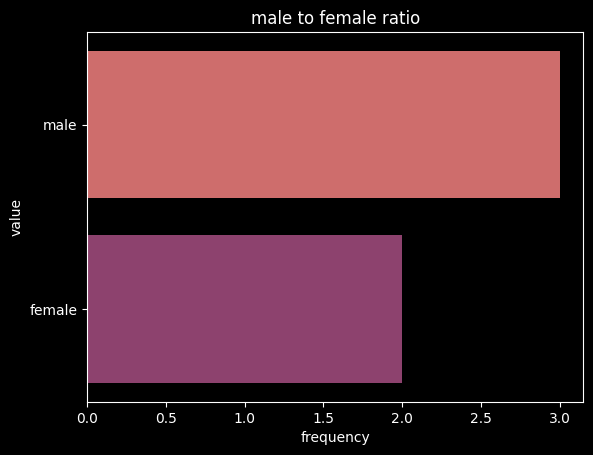

In [366]:
view_label_freq(dataset_df["label"].value_counts(), img_title="male to female ratio", save_img=True, labels=["male", "female"])

In [367]:
dataset_df["label"], dataset_df_le = encode_features(dataset_df["label"])
dataset_df

,subject_name,raw_signals,label
0,1028-20100710-hne,"[-0.012368511, -0.01195598, -0.011490619, -0.0...",1
1,1337ad-20170321-ajg,"[-0.016875517, -0.018209193, -0.019423367, -0....",0
2,1337ad-20170321-tkg,"[-0.0009385911, -0.0008081944, 2.851944e-05, 0...",0
3,1337ad-20170321-ynk,"[0.010538318, 0.008913219, 0.0072109867, 0.007...",0
4,1snoke-20120412-hge,"[0.002384291, 0.0010554284, -0.0014137251, -0....",1


### As we can see 1 is male and 0 is female

In [368]:
dataset_df_le.inverse_transform([0, 0, 0, 1])

array(['female', 'female', 'female', 'male'], dtype=object)

### We save this encoder for later when we run the training script

In [ ]:
save_model(dataset_df_le, './saved/misc/audio_dataset_le.pkl')

In [369]:
train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, random_state=0)

In [370]:
train_dataset_df

,subject_name,raw_signals,label
0,1028-20100710-hne,"[-0.012368511, -0.01195598, -0.011490619, -0.0...",1
1,1337ad-20170321-ajg,"[-0.016875517, -0.018209193, -0.019423367, -0....",0
3,1337ad-20170321-ynk,"[0.010538318, 0.008913219, 0.0072109867, 0.007...",0
4,1snoke-20120412-hge,"[0.002384291, 0.0010554284, -0.0014137251, -0....",1


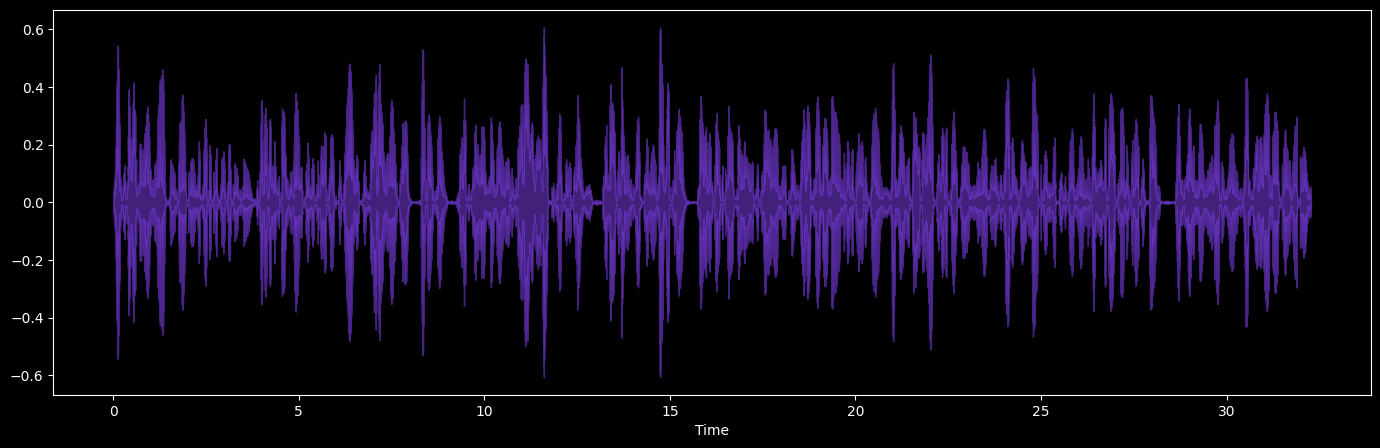

In [371]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(dataset_df.loc[0, "raw_signals"], alpha=0.5, color="#8442f5")
plt.show()

In [372]:
train_dataset = list(train_dataset_df.itertuples(index=False, name=None))
train_dataset

[('1028-20100710-hne',
  array([-0.01236851, -0.01195598, -0.01149062, ...,  0.00880105,
          0.00915327,  0.00915724], dtype=float32),
  1),
 ('1337ad-20170321-ajg',
  array([-0.01687552, -0.01820919, -0.01942337, ...,  0.00213481,
          0.00366674,  0.0044148 ], dtype=float32),
  0),
 ('1337ad-20170321-ynk',
  array([0.01053832, 0.00891322, 0.00721099, ..., 0.00111261, 0.00145421,
         0.00154072], dtype=float32),
  0),
 ('1snoke-20120412-hge',
  array([ 0.00238429,  0.00105543, -0.00141373, ...,  0.00074456,
         -0.02803531, -0.02505137], dtype=float32),
  1)]

In [373]:
test_dataset = list(test_dataset_df.itertuples(index=False, name=None))
test_dataset

[('1337ad-20170321-tkg',
  array([-9.3859108e-04, -8.0819440e-04,  2.8519440e-05, ...,
         -3.2456361e-02, -3.3746477e-02, -3.3912405e-02], dtype=float32),
  0)]

### All we havee to do now is to extract the features of each combined vector for each subject
### 521216 is the length of the 16000hz test audio signal 

In [374]:
from utilities.feature_extractors import extract_features

In [ ]:
# there are 16000 samples per second originally but
# if we let librosa interpolate our signals it would be 22050
hertz = 22050

# how many seconds we want our window to be
# e.g. if we want our signal segment to be 1 second
# then this would mean 16000 (or 22050) samples that we need to aggregate
# quarter of a second
window_time = 0.5

# how many seconds we want our signal segments to overlap
# one eighth of a second (1/8)
hop_time = 0.125

# note that the shorter the window time and hop time the more there will be data points in our final dataset
# which can be computationally intensive for our machine

In [376]:
train_dataset_final = extract_features(train_dataset, hertz=hertz, window_time=window_time, hop_time=hop_time)
train_dataset_final

1028-20100710-hne
samples per window size: 5512
samples per hop size: 1378
1337ad-20170321-ajg
samples per window size: 5512
samples per hop size: 1378
1337ad-20170321-ynk
samples per window size: 5512
samples per hop size: 1378
1snoke-20120412-hge
samples per window size: 5512
samples per hop size: 1378
number of frames resulting from window size of 5512                 and a hop size of 1378 from audio signal frequency of 22050: range(0, 514)
shape of time calculated from number of frames: 514
number of frames resulting from window size of 5512                 and a hop size of 1378 from audio signal frequency of 22050: range(0, 563)
shape of time calculated from number of frames: 563
number of frames resulting from window size of 5512                 and a hop size of 1378 from audio signal frequency of 22050: range(0, 556)
shape of time calculated from number of frames: 556
number of frames resulting from window size of 5512                 and a hop size of 1378 from audio signal 

((     mean_freq_kHz  median_freq_kHz  std_freq  mode_freq first_quartile_kHz  \
  0        -0.000568        -0.002676  0.085498  -0.542758  (-2.5490888e-05,)   
  1        -0.000854        -0.003452  0.085609  -0.542758  (-2.6353537e-05,)   
  2        -0.002324        -0.003621  0.055154  -0.529699  (-2.0475041e-05,)   
  3         0.001034        -0.001582  0.062417  -0.344249  (-1.7954411e-05,)   
  4        -0.000049        -0.002481  0.075652  -0.344249  (-2.8472075e-05,)   
  ..             ...              ...       ...        ...                ...   
  509       0.001203         0.000174  0.051147  -0.265813   (-1.850363e-05,)   
  510       0.000777         0.000673  0.052852  -0.208831  (-2.1815142e-05,)   
  511       0.000895         0.000786  0.052840  -0.170766  (-2.6586767e-05,)   
  512       0.001115         0.000623  0.050696  -0.170766  (-2.4792977e-05,)   
  513       0.000572         0.000602  0.046422  -0.170766   (-1.982563e-05,)   
  
      third_quartile_kHz 

In [377]:
train_dataset_final[0][0]

,mean_freq_kHz,median_freq_kHz,std_freq,mode_freq,first_quartile_kHz,third_quartile_kHz,inter_quartile_range_kHz,skewness,kurtosis,amp_env,rms,peak_frequency,zcr,label,subject_name
0,-0.000568,-0.002676,0.085498,-0.542758,"(-2.5490888e-05,)","(2.5373058e-05,)","(5.0863942e-05,)",-0.277909,6.719795,0.399955,0.085500,624.462891,0.018687,1,1028-20100710-hne
1,-0.000854,-0.003452,0.085609,-0.542758,"(-2.6353537e-05,)","(2.4025408e-05,)","(5.0378945e-05,)",-0.256709,6.662496,0.399955,0.085613,624.462891,0.033382,1,1028-20100710-hne
2,-0.002324,-0.003621,0.055154,-0.529699,"(-2.0475041e-05,)","(1.1796333e-05,)","(3.2271375e-05,)",0.049180,17.040449,0.399562,0.055203,139.965820,0.051524,1,1028-20100710-hne
3,0.001034,-0.001582,0.062417,-0.344249,"(-1.7954411e-05,)","(1.6202115e-05,)","(3.4156525e-05,)",0.649830,9.322095,0.391647,0.062426,452.197266,0.117743,1,1028-20100710-hne
4,-0.000049,-0.002481,0.075652,-0.344249,"(-2.8472075e-05,)","(2.3235354e-05,)","(5.1707433e-05,)",0.469351,4.143726,0.391647,0.075652,452.197266,0.127721,1,1028-20100710-hne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.001203,0.000174,0.051147,-0.265813,"(-1.850363e-05,)","(1.3935777e-05,)","(3.2439406e-05,)",0.410941,4.928854,0.296527,0.051161,86.132812,0.049165,1,1028-20100710-hne
510,0.000777,0.000673,0.052852,-0.208831,"(-2.1815142e-05,)","(1.9411396e-05,)","(4.1226536e-05,)",0.504541,2.936029,0.296527,0.052858,452.197266,0.043904,1,1028-20100710-hne
511,0.000895,0.000786,0.052840,-0.170766,"(-2.6586767e-05,)","(2.8442904e-05,)","(5.502967e-05,)",0.152351,0.943047,0.192131,0.052848,452.197266,0.039369,1,1028-20100710-hne
512,0.001115,0.000623,0.050696,-0.170766,"(-2.4792977e-05,)","(2.7264488e-05,)","(5.205747e-05,)",0.156385,1.162421,0.192131,0.050708,355.297852,0.031567,1,1028-20100710-hne


In [378]:
train_dataset_final[0][0].shape

(514, 15)

In [379]:
train_dataset_final[0][1]

,mean_freq_kHz,median_freq_kHz,std_freq,mode_freq,first_quartile_kHz,third_quartile_kHz,inter_quartile_range_kHz,skewness,kurtosis,amp_env,rms,peak_frequency,zcr,label,subject_name
0,-0.001470,0.003082,0.034840,-0.129570,"(-1.5928617e-05,)","(1.9637006e-05,)","(3.5565623e-05,)",-0.972835,1.544980,0.084206,0.034871,258.398438,0.013062,0,1337ad-20170321-ajg
1,-0.001186,0.005125,0.033941,-0.129570,"(-1.3543223e-05,)","(1.9820945e-05,)","(3.336417e-05,)",-1.137746,1.856731,0.084206,0.033962,10.766602,0.027939,0,1337ad-20170321-ajg
2,0.000845,0.006121,0.036648,0.030688,"(-1.24387925e-05,)","(2.0913065e-05,)","(3.335186e-05,)",-0.977150,2.706263,0.111164,0.036657,10.766602,0.054064,0,1337ad-20170321-ajg
3,-0.001241,0.005468,0.045017,0.030688,"(-2.0707917e-05,)","(2.4034178e-05,)","(4.4742097e-05,)",-0.817503,0.995823,0.111164,0.045034,473.730469,0.051524,0,1337ad-20170321-ajg
4,0.001822,0.009569,0.045961,0.030688,"(-2.360728e-05,)","(3.1148495e-05,)","(5.4755772e-05,)",-0.715117,0.572256,0.111164,0.045997,473.730469,0.053157,0,1337ad-20170321-ajg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,-0.000064,0.001417,0.011992,0.008277,"(-6.7306787e-06,)","(6.782256e-06,)","(1.3512935e-05,)",-0.193124,1.322749,0.040966,0.011992,10.766602,0.015784,0,1337ad-20170321-ajg
552,0.002717,0.003827,0.014815,0.008277,"(-4.791056e-06,)","(8.953061e-06,)","(1.37441175e-05,)",1.371842,8.942702,0.117229,0.015062,10.766602,0.013788,0,1337ad-20170321-ajg
553,-0.003852,0.000164,0.041330,0.011590,"(-1.6690774e-05,)","(1.04739465e-05,)","(2.716472e-05,)",-0.154801,4.350305,0.179449,0.041509,10.766602,0.013062,0,1337ad-20170321-ajg
554,-0.001051,0.004125,0.041275,0.011590,"(-7.58494e-06,)","(1.2405897e-05,)","(1.9990835e-05,)",-0.341530,4.450747,0.179449,0.041288,10.766602,0.017417,0,1337ad-20170321-ajg


In [380]:
train_dataset_merged = pd.concat(train_dataset_final[0], axis=0, ignore_index=True)
train_dataset_merged

,mean_freq_kHz,median_freq_kHz,std_freq,mode_freq,first_quartile_kHz,third_quartile_kHz,inter_quartile_range_kHz,skewness,kurtosis,amp_env,rms,peak_frequency,zcr,label,subject_name
0,-0.000568,-0.002676,0.085498,-0.542758,"(-2.5490888e-05,)","(2.5373058e-05,)","(5.0863942e-05,)",-0.277909,6.719795,0.399955,0.085500,624.462891,0.018687,1,1028-20100710-hne
1,-0.000854,-0.003452,0.085609,-0.542758,"(-2.6353537e-05,)","(2.4025408e-05,)","(5.0378945e-05,)",-0.256709,6.662496,0.399955,0.085613,624.462891,0.033382,1,1028-20100710-hne
2,-0.002324,-0.003621,0.055154,-0.529699,"(-2.0475041e-05,)","(1.1796333e-05,)","(3.2271375e-05,)",0.049180,17.040449,0.399562,0.055203,139.965820,0.051524,1,1028-20100710-hne
3,0.001034,-0.001582,0.062417,-0.344249,"(-1.7954411e-05,)","(1.6202115e-05,)","(3.4156525e-05,)",0.649830,9.322095,0.391647,0.062426,452.197266,0.117743,1,1028-20100710-hne
4,-0.000049,-0.002481,0.075652,-0.344249,"(-2.8472075e-05,)","(2.3235354e-05,)","(5.1707433e-05,)",0.469351,4.143726,0.391647,0.075652,452.197266,0.127721,1,1028-20100710-hne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,-0.000020,0.002888,0.043915,-0.224680,"(-1.5479955e-05,)","(1.8323904e-05,)","(3.380386e-05,)",-0.272409,3.488419,0.190849,0.043915,506.030273,0.062409,1,1snoke-20120412-hge
2231,0.000253,0.003044,0.044866,-0.321051,"(-1.3916517e-05,)","(1.7533648e-05,)","(3.1450167e-05,)",-0.675974,6.081174,0.214367,0.044867,667.529297,0.054064,1,1snoke-20120412-hge
2232,0.000325,0.003423,0.051006,-0.321051,"(-1.3280692e-05,)","(1.7935145e-05,)","(3.1215834e-05,)",-0.365471,6.739605,0.352854,0.051007,667.529297,0.053701,1,1snoke-20120412-hge
2233,0.000235,0.002279,0.052403,-0.321051,"(-1.5746342e-05,)","(1.8908828e-05,)","(3.4655168e-05,)",-0.307950,5.967546,0.352854,0.052403,667.529297,0.069303,1,1snoke-20120412-hge


### We visualize the calculated root mean squared energy of the audio signal

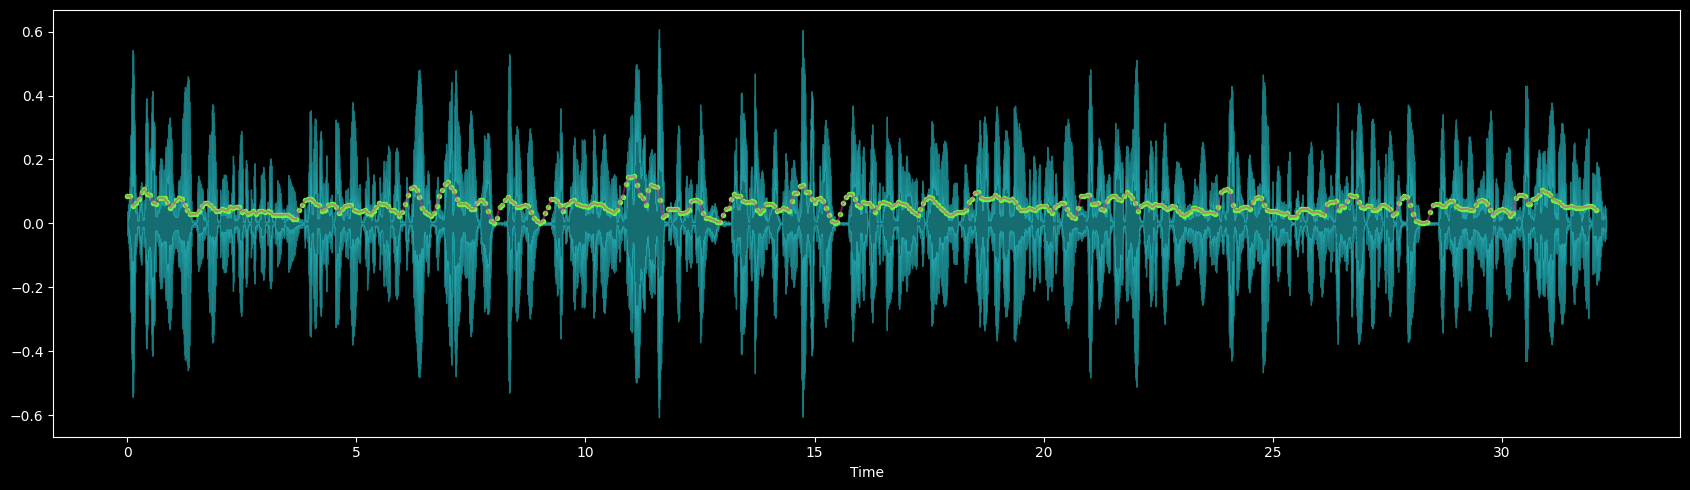

In [381]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(dataset_df.loc[0, "raw_signals"], alpha=0.5, color="#2ddae3")

time = train_dataset_final[1][0]
plt.scatter(time, train_dataset_final[0][0]["rms"], color="#6cf542", marker='.', alpha=1)
plt.plot(time, train_dataset_final[0][0]["rms"], color="#e02f8e", alpha=0.5)
plt.tight_layout()
plt.show()

### Zero crossing rate feature of audio signal

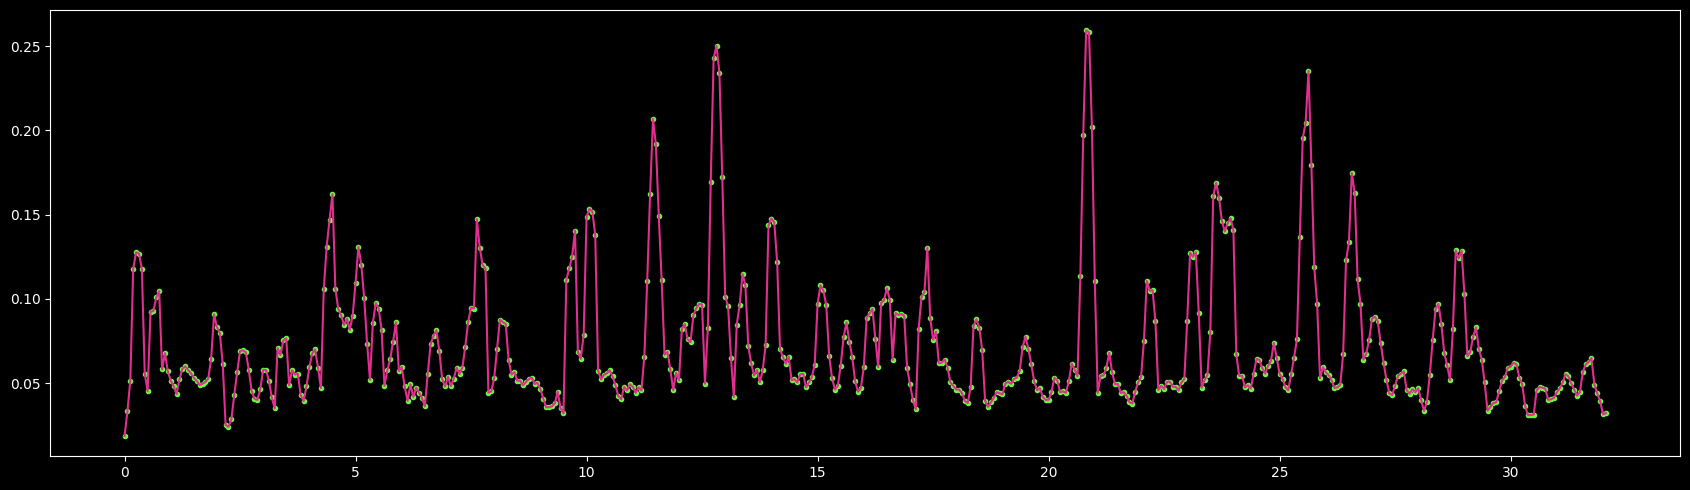

In [382]:
fig = plt.figure(figsize=(17, 5))
time = train_dataset_final[1][0]
plt.scatter(time, train_dataset_final[0][0]["zcr"], color="#6cf542", marker='.', alpha=1)
plt.plot(time, train_dataset_final[0][0]["zcr"], color="#e02f8e", alpha=1)
plt.tight_layout()
plt.show()

### For deep learning however and the use of LSTMs and CNNs and of its ilk we can use raw audio signals themselves to extract deep features from. As we know these models are able to extract higher order features automatically

In [386]:
dl_train_dataset_final = extract_features(train_dataset, hertz=hertz, window_time=window_time, hop_time=hop_time, config="deep")

1028-20100710-hne
samples per window size: 5512
samples per hop size: 1378
n padding to be added: 746
1337ad-20170321-ajg
samples per window size: 5512
samples per hop size: 1378
n padding to be added: 1278
1337ad-20170321-ynk
samples per window size: 5512
samples per hop size: 1378
n padding to be added: 1299
1snoke-20120412-hge
samples per window size: 5512
samples per hop size: 1378
n padding to be added: 666
number of frames resulting from window size of 5512             and a hop size of 1378 from audio signal frequency of 22050: range(0, 0)
shape of time calculated from number of frames: 0
number of frames resulting from window size of 5512             and a hop size of 1378 from audio signal frequency of 22050: range(0, 0)
shape of time calculated from number of frames: 0
number of frames resulting from window size of 5512             and a hop size of 1378 from audio signal frequency of 22050: range(0, 0)
shape of time calculated from number of frames: 0
number of frames result

In [393]:
dl_train_signals_merged = np.concatenate(dl_train_dataset_final[0], axis=0)
dl_train_signals_merged

array([[[-1.2368511e-02],
        [-1.1955980e-02],
        [-1.1490619e-02],
        ...,
        [ 4.4086920e-03],
        [-1.6365066e-02],
        [-1.8928323e-02]],

       [[ 2.6246361e-02],
        [ 3.3504162e-02],
        [ 4.0434077e-02],
        ...,
        [-2.0689256e-02],
        [-1.6414933e-02],
        [-1.4000530e-02]],

       [[ 2.7307948e-01],
        [ 2.9815802e-01],
        [ 3.2997185e-01],
        ...,
        [ 5.2368239e-02],
        [ 5.9218038e-02],
        [ 5.1027194e-02]],

       ...,

       [[ 2.2848537e-03],
        [ 4.0771514e-03],
        [ 5.9306752e-03],
        ...,
        [ 5.6430530e-03],
        [ 1.0823645e-04],
        [-5.4849759e-03]],

       [[ 1.6224198e-02],
        [ 1.2475790e-02],
        [ 9.7785760e-03],
        ...,
        [ 2.7532552e-03],
        [ 3.3379160e-03],
        [ 2.9770969e-03]],

       [[ 4.9560107e-02],
        [ 1.5844416e-02],
        [-1.1235930e-02],
        ...,
        [-2.5051367e-02],
        [-2.505

In [394]:
dl_train_labels_merged = np.concatenate(dl_train_dataset_final[1], axis=0)
dl_train_labels_merged

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [395]:
# again in lstms we have the concept of timesteps
# but in the case of signal processing especially biosignal
# and audio processing the number of features can sometimes be
# just 1 dimension and the timesteps could be the window size itself
m, tx, nf  = dl_train_signals_merged.shape

In [398]:
dl_train_labels_merged.shape

(2235, 1)

In [396]:
m, tx, nf

(2235, 5512, 1)